<a href="https://colab.research.google.com/github/AnzhelikaKodlubovska/First_repo/blob/main/Hw9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output, display, Math

In [3]:
from keras.datasets import fashion_mnist

In [4]:
pip install keras

In [5]:
class_labels = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress',
                4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}
input_shape = (28, 28, 1)
num_classes = 10

In [6]:
# Завантажуємо датасет і розділимо його на навчальну та тестову вибірки
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Нормалізуємо значення пікселів, щоб значення пікселів знаходилось у проміжку від 0 до 1
x_train, x_test = x_train / 255., x_test / 255.

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


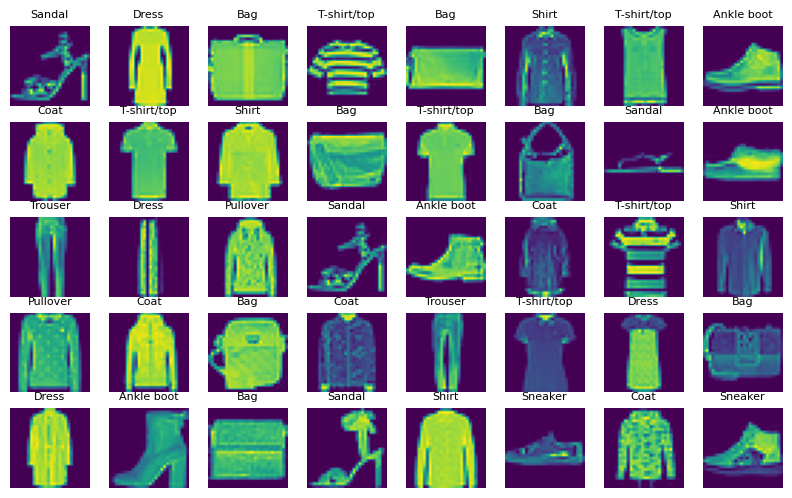

In [7]:
number_of_images = 40
f, ax = plt.subplots(5, 8, figsize=(10, 6))

for i, sample_index in enumerate(np.random.randint(1, x_test.shape[0], number_of_images)):
    test_image = x_test[sample_index].reshape(1, -1)
    test_item = y_test[sample_index]
    ax[i//8, i % 8].imshow(test_image[0].reshape((28, 28)))
    ax[i//8, i % 8].axis('off')
    ax[i//8, i %
        8].set_title(f"{class_labels.get(test_item)}", fontsize=8)
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


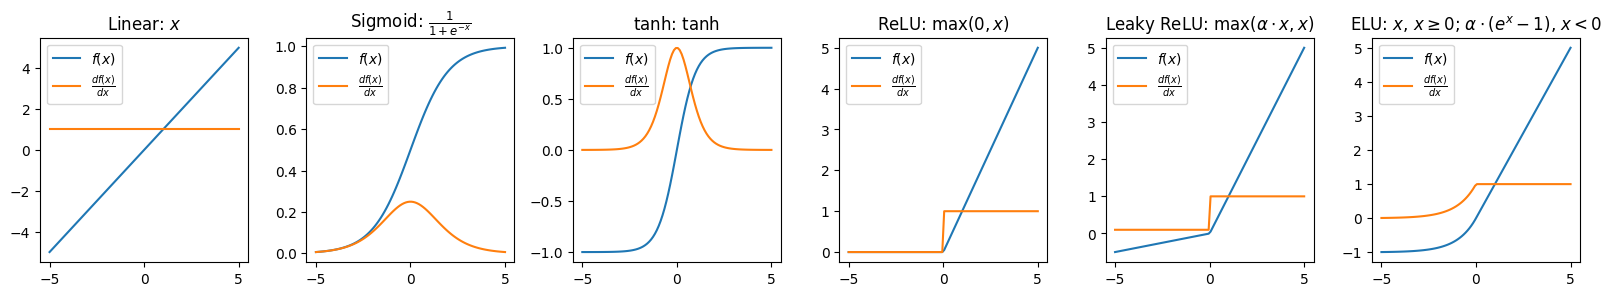

In [8]:
from tensorflow.keras.activations import linear, sigmoid, tanh, relu
from tensorflow.keras.layers import LeakyReLU, ELU

x = np.linspace(-5, 5, 100)
x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)

activation_functions = [linear, sigmoid, tanh, relu, LeakyReLU(alpha=0.1), ELU(alpha=1.0)]
activation_names = ['Linear', 'Sigmoid', 'tanh', 'ReLU', 'Leaky ReLU', 'ELU']
analitic = [r'$x$', r'$\frac{1}{1 + e^{-x}}$', r'$\tanh$', r'$\max(0, x)$', r'$\max(\alpha\cdot x, x)$', r'$x$, $x \geq 0$; $\alpha\cdot(e^x - 1)$, $x < 0$']


plt.figure(figsize=(16, 16))

for i in range(len(activation_functions)):
    activation_name = activation_names[i]

    plt.subplot(6, 6, i + 1)
    plt.plot(x, activation_functions[i](x_tensor).numpy(), label=r'$f(x)$')
    plt.title(f'{activation_name}: {analitic[i]}')

    with tf.GradientTape() as tape:
        tape.watch(x_tensor)
        y = activation_functions[i](x_tensor)
    derivative = tape.gradient(y, x_tensor).numpy()
    plt.plot(x, derivative, label=r'$\frac{df(x)}{dx}$')
    plt.legend()

plt.tight_layout()
plt.show()

In [9]:
# Побудова архітектури моделі
keras.utils.set_random_seed(42)

def build_model(learning_rate, l2_parameter):
    model = keras.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28, 1)))
    model.add(layers.Dense(128, activation='relu',
        kernel_regularizer=regularizers.l2(l2_parameter)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(64, activation='relu',
        kernel_regularizer=regularizers.l2(l2_parameter)))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(10, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'],
                  )
    return model

In [11]:
epochs = 30
steps_per_epoch = 1_000
batch_size = 2 * 64
l2_parameter = 1e-4
learning_rate = 1e-3

In [12]:
model = build_model(learning_rate, l2_parameter)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(256).prefetch(1)


# Навчання моделі
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, y_test)
)

# Оцінка моделі на тестовому наборі даних
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f'\nТочність на тестовому наборі: {test_accuracy:.2f}')

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6963 - loss: 0.8990 - val_accuracy: 0.8425 - val_loss: 0.4760
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8373 - loss: 0.4897 - val_accuracy: 0.8560 - val_loss: 0.4321
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8524 - loss: 0.4441 - val_accuracy: 0.8577 - val_loss: 0.4238
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8620 - loss: 0.4192 - val_accuracy: 0.8634 - val_loss: 0.4087
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8668 - loss: 0.4035 - val_accuracy: 0.8666 - val_loss: 0.4066
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8704 - loss: 0.3942 - val_accuracy: 0.8704 - val_loss: 0.3943
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8758 - loss: 0.3829 - val_accuracy: 0.8727 - val_loss: 0.3898
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8754 - loss: 0.3783 - val_accuracy: 0

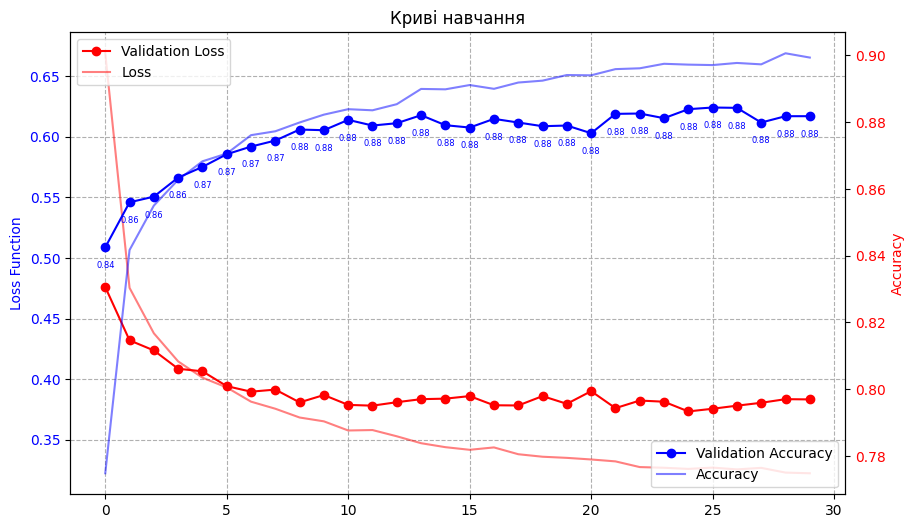

In [14]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(history.history['val_loss'], label='Validation Loss', marker='o', color='r')
ax1.plot(history.history['loss'], label='Loss', color='r', alpha=0.5)
ax1.set_ylabel('Loss Function', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()

ax2.plot(history.history['val_accuracy'], label='Validation Accuracy',  marker='o', color='b')
ax2.plot(history.history['accuracy'], label='Accuracy', color='b', alpha=0.5)

for i, acc in enumerate(history.history['val_accuracy']):
    ax2.annotate(f'{acc:.2f}', (i, acc), textcoords="offset points", xytext=(0, -15), ha='center', c='b', fontsize=6)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax1.grid(True, linestyle='--')

ax1.legend(loc='upper left')
ax2.legend(loc='lower right')

plt.title('Криві навчання')

plt.show()

In [16]:
predictions = model.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


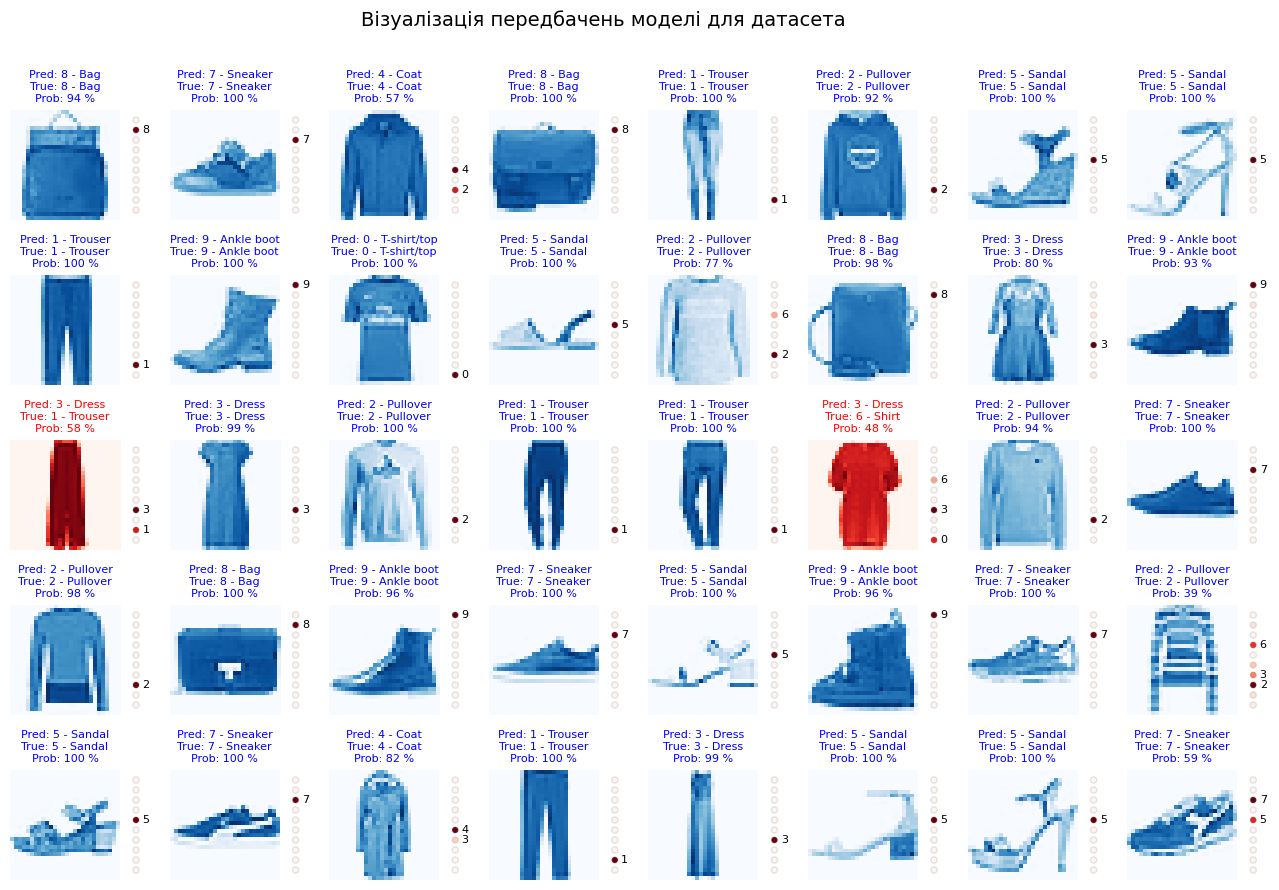

In [17]:
number_of_images = 40
f, ax = plt.subplots(5, 8, figsize=(16, 10))
f.subplots_adjust(hspace=0.5, wspace=0.3)

f.suptitle("Візуалізація передбачень моделі для датасета", fontsize=14)


for axes_index, sample_index in enumerate(np.random.choice(10000, number_of_images)):
    prob = predictions[sample_index]
    img, true_label = x_test[sample_index], y_test[sample_index]
    predicted_label = np.argmax(prob)
    if predicted_label == true_label:
        color = 'blue'
        cmap = 'Blues'
    else:
        color = 'red'
        cmap = 'Reds'

    ax[axes_index//8, axes_index % 8].imshow(img, cmap=cmap)
    ax[axes_index//8, axes_index % 8].axis('off')
    ax[axes_index//8, axes_index %
        8].set_title(f"Pred: {predicted_label} - {class_labels.get(predicted_label)}\nTrue: {true_label} - {class_labels.get(true_label)}\nProb: {prob.max()*100:.0f} %", fontsize=8, color=color)

    inset_ax = f.add_axes([ax[axes_index//8, axes_index % 8].get_position().x1, ax[axes_index//8, axes_index % 8].get_position().y0, 0.02, ax[axes_index//8, axes_index % 8].get_position().height])

    classes = np.arange(len(class_labels))
    inset_ax.scatter(np.ones(10)*0.5,
                     classes,
                     s=20,
                     c=prob,
                     cmap='Reds',
                     marker='o',
                     edgecolor=(0.5, 0.5, 0.5, 0.2),
                     linewidths=1,
                     )
    inset_ax.set_xlim(0, 1)
    inset_ax.set_ylim(-1, 10)
    inset_ax.set_xticks([])
    inset_ax.set_yticks([])
    inset_ax.axis('off')
    for i, p in enumerate(prob):
        if p > 0.1:
            inset_ax.text(0.7, i, f'{i}', fontsize=8, verticalalignment='center')

plt.show()